Multi_Modal_Sentiment_Anaylsis Overview
1. Read and process the dataset (images, text, and their labels) and divide into train and test dataset.
2. Build, train and evaluate a CNN which only uses images for sentiment analysis
3. Build, train and evaluate a Text model which only uses the text data for sentiment analalysis
4. Build, train and evaluate a combined model which uses both visual and text data.
5. Do a performance comparsion of these three different kinds of models.

Here's how the combined model would look like.

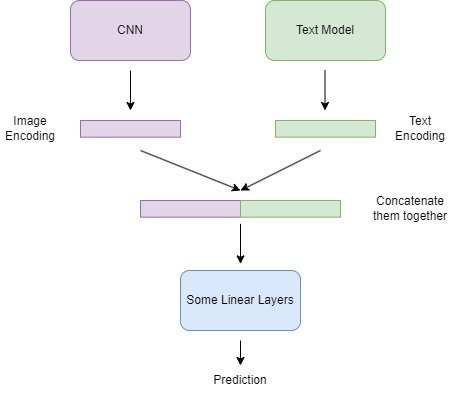

In [ ]:
!gdown "1w2zPSfyAoSopS-BhFurKayYa_OhjI9YH"


Downloading...
From (original): https://drive.google.com/uc?id=1w2zPSfyAoSopS-BhFurKayYa_OhjI9YH
From (redirected): https://drive.google.com/uc?id=1w2zPSfyAoSopS-BhFurKayYa_OhjI9YH&confirm=t&uuid=61afc659-71b5-4909-8644-bf5a635d588e
To: /content/MVSA-Single.zip
100% 211M/211M [00:00<00:00, 270MB/s]


In [ ]:
!unzip MVSA-Single.zip

Archive:  MVSA-Single.zip
replace MVSA_Single/data/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import tensorflow as tf

TensorFlow version: 2.15.0


In [ ]:
pip install -U tf2onnx

Imports

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision import datasets, models
import os
from PIL import Image
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix as sklearn_confusion_matrix

Loading the image and text data

In [ ]:
base_dr = 'MVSA_Single'

# loading and assigning numers to the label data
label_file = os.path.join(base_dr, 'labelResultAll.csv')
labels_df = pd.read_csv(label_file)
label_map = {'positive': 1, 'negative': 0, 'neutral': 2}
labels_df['label'] = labels_df['label'].apply(lambda x: label_map.get(x))

# creating a directory for the rest of the data
data_dr = os.path.join(base_dr, 'data')

# Define transform for images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define a class for loading images
class ImageDataset(torch.utils.data.Dataset):

    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

# Function to load text
def load_text(text_paths):
    texts = []
    for text_path in text_paths:
        with open(text_path, 'r', encoding='latin-1') as f:
            text = f.read()
        texts.append(text)
    return texts

# Load paths for image and text files from 'MVSA_Single/data'
image_files = sorted([os.path.join(data_dr, f) for f in os.listdir(data_dr) if f.endswith('.jpg')])
text_files = sorted([os.path.join(data_dr, f) for f in os.listdir(data_dr) if f.endswith('.txt')])

# loading text data
texts = load_text(text_files)
images = ImageDataset(image_files, labels_df['label'].values, transform=transform)
# preprocessing the text data using the Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts) # The text is tokenised and each word is given an index based on the frequency it appears
sequences = tokenizer.texts_to_sequences(texts) # Converting each text to a series of integers
padded_sequences = pad_sequences(sequences, maxlen=100, padding='post') # Padding the sequences to a maximum length of 100

# Checking the lengths to see that no data has been lost
print(len(images))
print(len(texts))
print(len(labels_df))
print(len(padded_sequences))


4869
4869
4869
4869


Splitting the dataset into train and test sets

In [ ]:
train_images, test_images, train_texts, test_texts, train_labels, test_labels = train_test_split(
    image_files, padded_sequences, labels_df['label'].values, test_size=0.2, random_state=42)

Data loader for the images

In [ ]:
class ImageDataLoader(DataLoader):
    def __init__(self, dataset, batch_size=32, shuffle=True):
        super().__init__(dataset, batch_size=batch_size, shuffle=shuffle)

train_dataset = ImageDataset(train_images, train_labels, transform=transform)
test_dataset = ImageDataset(test_images, test_labels, transform=transform)

train_loader = ImageDataLoader(train_dataset)
test_loader = ImageDataLoader(test_dataset)

CNN model for the image data set

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 28 * 28, 128)
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, (2, 2))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, (2, 2))
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, (2, 2))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# creating an instance of the network

C_net = CNN()

Defining GPU processing and applying to CNN

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
C_net.to(device)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=100352, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)

Training the CNN

 10%|█         | 1/10 [00:44<06:41, 44.63s/it]

 Training accuracy = 54.63414634146342
Training loss = 1.0237739066608618


 20%|██        | 2/10 [01:18<05:07, 38.39s/it]

 Training accuracy = 55.27599486521181
Training loss = 0.9952027348221325


 30%|███       | 3/10 [01:51<04:11, 35.92s/it]

 Training accuracy = 55.27599486521181
Training loss = 0.9950745027573382


 40%|████      | 4/10 [02:27<03:34, 35.77s/it]

 Training accuracy = 55.27599486521181
Training loss = 0.9946729384484838


 50%|█████     | 5/10 [03:01<02:55, 35.08s/it]

 Training accuracy = 55.27599486521181
Training loss = 0.9935513632219346


 60%|██████    | 6/10 [03:33<02:17, 34.29s/it]

 Training accuracy = 55.30166880616174
Training loss = 0.9922922385520623


 70%|███████   | 7/10 [04:07<01:42, 34.14s/it]

 Training accuracy = 55.30166880616174
Training loss = 0.9833552480721083


 80%|████████  | 8/10 [04:40<01:07, 33.73s/it]

 Training accuracy = 55.37869062901155
Training loss = 0.9667831195182488


 90%|█████████ | 9/10 [05:13<00:33, 33.51s/it]

 Training accuracy = 57.81771501925546
Training loss = 0.9239899540533785


100%|██████████| 10/10 [05:47<00:00, 34.73s/it]

 Training accuracy = 60.66752246469833
Training loss = 0.8542778824196487


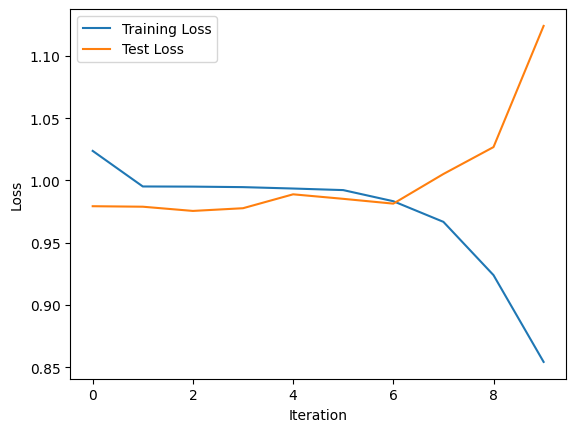

In [ ]:
# Training and testing the neural network on the data
num_iter = 10

# optimisation function
opt = optim.SGD(C_net.parameters(), lr=0.1, momentum=0.5)

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
cnn_predictions = []

#beginning the training
for i in tqdm(range(num_iter)):
    C_net.train()  # setc the network to training mode
    running_loss = 0.0
    total_train = 0
    correctly_labelled_train = 0

    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)

        yhat = C_net(x)  # forward pass
        loss = F.cross_entropy(yhat, y)  # loss

        opt.zero_grad()  # optimization
        loss.backward()  # back pass
        opt.step()  # opt step

        running_loss += loss.item()
        yhat = torch.argmax(yhat, dim=1)
        total_train += y.size(0)
        correctly_labelled_train += (yhat == y).sum().item()

    iter_loss = running_loss / len(train_loader)
    train_losses.append(iter_loss)
    train_accuracy = correctly_labelled_train / total_train * 100
    train_accuracies.append(train_accuracy)

    # Now testing
    C_net.eval()  # set the network to evaluation mode
    correctly_labelled_test = 0
    total_test = 0
    test_loss = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)
            logits = C_net(x)
            loss = F.cross_entropy(logits, y)
            test_loss += loss.item()
            yhat = torch.argmax(logits, dim=1)
            correctly_labelled_test += (yhat == y).sum().item()
            total_test += y.size(0)

            cnn_predictions = np.append(cnn_predictions, yhat.cpu().numpy())

    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    test_accuracy = correctly_labelled_test / total_test * 100
    test_accuracies.append(test_accuracy)

    print(f" Training accuracy = {train_accuracy}")
    print(f"Training loss = {iter_loss}")

plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

This model shows that the CNN is overfitting past epoch 4, however up to epoch 4 the accuracy is constant. Therefore, I will use resnet18 to see if a different neural network also gives a constant accuracy, which would imply the images alone have little relevance to the emotion behind the post.

Using resnet18

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 25%|██▌       | 1/4 [00:47<02:21, 47.20s/it]

 Training accuracy = 50.60333761232349
Training loss = 1.064237054254188


 50%|█████     | 2/4 [01:23<01:21, 40.76s/it]

 Training accuracy = 55.04492939666239
Training loss = 0.9549508285327036


 75%|███████▌  | 3/4 [02:01<00:39, 39.50s/it]

 Training accuracy = 60.61617458279846
Training loss = 0.8511633316024405


100%|██████████| 4/4 [02:37<00:00, 39.47s/it]

 Training accuracy = 70.65468549422337
Training loss = 0.7142782963690211


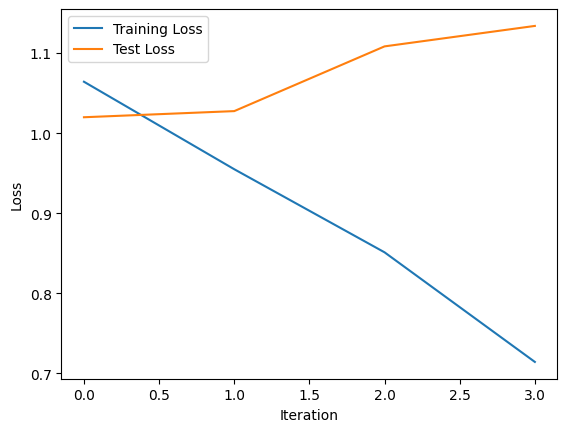

In [ ]:
cnn_model = models.resnet18(pretrained=True)

# Modify the final layer to match the number of classes (3 in this case)
num_features = cnn_model.fc.in_features
cnn_model.fc = nn.Linear(num_features, 3)

cnn_model = cnn_model.to(device)

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn_model.parameters(), lr=0.001, momentum=0.9)

# Training and testing the neural network on the data
num_epochs = 4

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Beginning the training
for epoch in tqdm(range(num_epochs)):
    cnn_model.train()  # set the network to training mode
    running_loss = 0.0
    total_train = 0
    correctly_labelled_train = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()  # optimization
        outputs = cnn_model(inputs)  # forward pass
        loss = criterion(outputs, labels)  # loss

        loss.backward()  # back pass
        optimizer.step()  # optimizer step

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correctly_labelled_train += (predicted == labels).sum().item()

    iter_loss = running_loss / len(train_loader)
    train_losses.append(iter_loss)
    train_accuracy = correctly_labelled_train / total_train * 100
    train_accuracies.append(train_accuracy)

    # Adjust learning rate
    scheduler.step()

    # Now testing
    cnn_model.eval()  # set the network to evaluation mode
    correctly_labelled_test = 0
    total_test = 0
    test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = cnn_model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correctly_labelled_test += (predicted == labels).sum().item()
            total_test += labels.size(0)

    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    test_accuracy = correctly_labelled_test / total_test * 100
    test_accuracies.append(test_accuracy)

    print(f" Training accuracy = {train_accuracy}")
    print(f"Training loss = {iter_loss}")

plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

From the 2 networks above we can conclude that the images alone do not give any inclination of the emotion behind the tweet.

Creating a dataset out of the text data

In [ ]:
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        return torch.tensor(text, dtype=torch.long), torch.tensor(label, dtype=torch.long)

Creating a dataloader for the text

In [ ]:
train_dataset_text = TextDataset(train_texts, train_labels)
test_dataset_text = TextDataset(test_texts, test_labels)

train_text_loader = DataLoader(train_dataset_text, batch_size = 32, shuffle = True)
test_text_loader = DataLoader(test_dataset_text, batch_size = 32, shuffle = False)

In [ ]:
class TextRNN(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size):
        super(TextRNN, self).__init__()
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.RNN(embedding_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.rnn(x)
        x = self.dropout(x)
        x = self.fc(x[:, -1, :])
        x = self.relu(x)
        x = self.softmax(x)
        return x

 20%|██        | 1/5 [00:00<00:02,  1.78it/s]

 Training accuracy = 53.47881899871631
Training loss = 1.0173404886097204


 40%|████      | 2/5 [00:01<00:01,  1.92it/s]

 Training accuracy = 55.27599486521181
Training loss = 0.9977078213066352


 60%|██████    | 3/5 [00:01<00:01,  1.99it/s]

 Training accuracy = 55.27599486521181
Training loss = 0.9979657081306957


 80%|████████  | 4/5 [00:02<00:00,  1.98it/s]

 Training accuracy = 55.27599486521181
Training loss = 0.9979668113051868


100%|██████████| 5/5 [00:02<00:00,  1.98it/s]

 Training accuracy = 55.27599486521181
Training loss = 0.9971536305107054


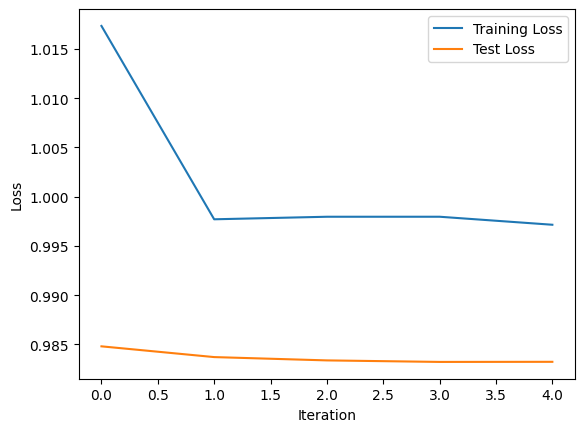

In [ ]:
input_size = len(tokenizer.word_index) + 1  # gives total number of unique words, where the +1 is for padding
embedding_size = 128 # each word represented by a vector of this size
hidden_size = 256    #
output_size = 3
num_epochs = 5

rnn_model = TextRNN(input_size, embedding_size, hidden_size, output_size)
rnn_model = rnn_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(rnn_model.parameters(), lr=0.001, momentum=0.9)

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
rnn_predictions = []

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Beginning the training
for epoch in tqdm(range(num_epochs)):
    rnn_model.train()  # set the network to training mode
    running_loss = 0.0
    total_train = 0
    correctly_labelled_train = 0

    for inputs, labels in train_text_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()  # optimization
        outputs = rnn_model(inputs)  # forward pass
        loss = criterion(outputs, labels)  # loss

        loss.backward()  # back pass
        optimizer.step()  # optimizer step

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correctly_labelled_train += (predicted == labels).sum().item()

    iter_loss = running_loss / len(train_text_loader)
    train_losses.append(iter_loss)
    train_accuracy = correctly_labelled_train / total_train * 100
    train_accuracies.append(train_accuracy)

    # Adjust learning rate
    scheduler.step()

    # Now testing
    rnn_model.eval()  # set the network to evaluation mode
    correctly_labelled_test = 0
    total_test = 0
    test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_text_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = rnn_model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correctly_labelled_test += (predicted == labels).sum().item()
            total_test += labels.size(0)
            rnn_predictions = np.append(rnn_predictions, predicted.cpu().numpy())

    test_loss /= len(test_text_loader)
    test_losses.append(test_loss)
    test_accuracy = correctly_labelled_test / total_test * 100
    test_accuracies.append(test_accuracy)

    print(f" Training accuracy = {train_accuracy}")
    print(f"Training loss = {iter_loss}")

plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

Doing the combined model

In [ ]:
class CombinedModel(nn.Module):
    def __init__(self, C_net, rnn_net, num_classes):
        super(CombinedModel, self).__init__()
        self.cnn = C_net.to(device)
        self.cnn.fc2 = nn.Linear(self.cnn.fc2.in_features, 256)

        self.rnn = rnn_model.to(device)
        self.rnn.fc = nn.Linear(self.rnn.fc.in_features, 256)

        for param in self.cnn.fc2.parameters():
            param.requires_grad = True

        for param in self.rnn.parameters():
            param.requires_grad = False

        for param in self.rnn.fc.parameters():
            param.requires_grad = True

        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 128)
        self.leaky = nn.LeakyReLU()
        self.output = nn.Linear(128,3)

    def forward(self, image, text):
        image = self.cnn(image)
        text = self.rnn(text)

        x = torch.cat([image, text], dim=1)
        x = self.fc1(x)
        x = self.leaky(x)
        x = self.fc2(x)
        x = self.leaky(x)
        x = self.output(x)
        return x



In [ ]:
class CombinedDataset(Dataset):
    def __init__(self, image_paths, texts, labels, transform=None):
        self.image_paths = image_paths
        self.texts = texts
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        text = self.texts[idx]
        label = self.labels[idx]
        return image, text, label

In [ ]:
train_dataset = CombinedDataset(train_images, train_texts, train_labels, transform=transform)
test_dataset = CombinedDataset(test_images, test_texts, test_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

  5%|▌         | 1/20 [00:33<10:44, 33.94s/it]

 Training accuracy = 55.27599486521181
Training loss = 0.799256868294028
Test accuracy = 56.98151950718686


 10%|█         | 2/20 [01:07<10:11, 33.98s/it]

 Training accuracy = 55.27599486521181
Training loss = 0.6545872744478163
Test accuracy = 56.98151950718686


 15%|█▌        | 3/20 [01:40<09:30, 33.56s/it]

 Training accuracy = 55.27599486521181
Training loss = 0.5217966111224206
Test accuracy = 56.98151950718686


 20%|██        | 4/20 [02:15<09:00, 33.76s/it]

 Training accuracy = 55.27599486521181
Training loss = 0.3548745585636037
Test accuracy = 56.98151950718686


 25%|██▌       | 5/20 [02:48<08:24, 33.63s/it]

 Training accuracy = 55.27599486521181
Training loss = 0.26374684652832686
Test accuracy = 56.98151950718686


 30%|███       | 6/20 [03:22<07:51, 33.66s/it]

 Training accuracy = 55.27599486521181
Training loss = 0.20167667538568865
Test accuracy = 56.98151950718686


 35%|███▌      | 7/20 [03:56<07:19, 33.82s/it]

 Training accuracy = 55.27599486521181
Training loss = 0.176958144337061
Test accuracy = 56.98151950718686


 40%|████      | 8/20 [04:29<06:43, 33.65s/it]

 Training accuracy = 55.27599486521181
Training loss = 0.1438983104832959
Test accuracy = 56.98151950718686


 45%|████▌     | 9/20 [05:03<06:11, 33.80s/it]

 Training accuracy = 55.27599486521181
Training loss = 0.11243224597429155
Test accuracy = 56.98151950718686


 50%|█████     | 10/20 [05:37<05:38, 33.89s/it]

 Training accuracy = 55.27599486521181
Training loss = 0.08860345254270513
Test accuracy = 56.98151950718686


 55%|█████▌    | 11/20 [06:10<05:02, 33.63s/it]

 Training accuracy = 55.27599486521181
Training loss = 0.0960806048910332
Test accuracy = 56.98151950718686


 60%|██████    | 12/20 [06:45<04:30, 33.80s/it]

 Training accuracy = 55.27599486521181
Training loss = 0.11284818778150395
Test accuracy = 56.98151950718686


 65%|██████▌   | 13/20 [07:18<03:55, 33.71s/it]

 Training accuracy = 55.27599486521181
Training loss = 0.09961922708364418
Test accuracy = 56.98151950718686


 70%|███████   | 14/20 [07:52<03:21, 33.65s/it]

 Training accuracy = 55.27599486521181
Training loss = 0.0847537792368876
Test accuracy = 56.98151950718686


 75%|███████▌  | 15/20 [08:25<02:48, 33.73s/it]

 Training accuracy = 55.27599486521181
Training loss = 0.054484470422975106
Test accuracy = 56.98151950718686


 80%|████████  | 16/20 [08:59<02:14, 33.53s/it]

 Training accuracy = 55.27599486521181
Training loss = 0.03825722430260388
Test accuracy = 56.98151950718686


 85%|████████▌ | 17/20 [09:32<01:40, 33.62s/it]

 Training accuracy = 55.27599486521181
Training loss = 0.03253651525787451
Test accuracy = 56.98151950718686


 90%|█████████ | 18/20 [10:06<01:07, 33.72s/it]

 Training accuracy = 55.27599486521181
Training loss = 0.03135815193440305
Test accuracy = 56.98151950718686


 95%|█████████▌| 19/20 [10:40<00:33, 33.61s/it]

 Training accuracy = 55.27599486521181
Training loss = 0.03140168863177171
Test accuracy = 56.98151950718686


100%|██████████| 20/20 [11:14<00:00, 33.70s/it]

 Training accuracy = 55.27599486521181
Training loss = 0.02962679115436734
Test accuracy = 56.98151950718686


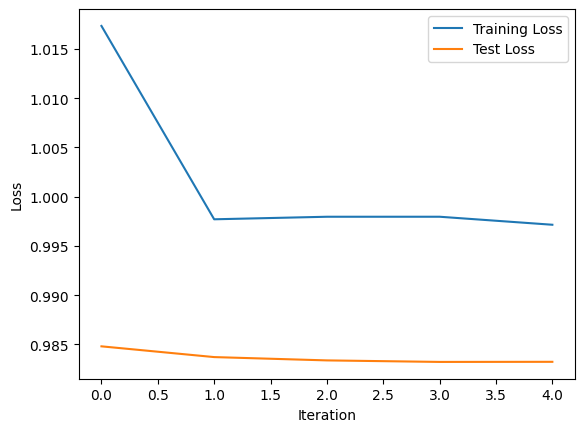

In [ ]:
#creating an instance of the network

comb_net = CombinedModel(C_net,rnn_model,3)
comb_net = comb_net.to(device)

# Training and testing the neural network on the data
num_iter = 20

# optimisation function
opt = optim.SGD(comb_net.parameters(), lr=0.1, momentum=0.5)

comb_train_losses = []
comb_train_accuracies = []
comb_test_losses = []
comb_test_accuracies = []
comb_predictions = []
comb_test_loss = 0.0

#beginning the training
for i in tqdm(range(num_iter)):
    comb_net.train()  # set the network to training mode
    comb_predictions = []
    running_loss = 0.0
    total_train = 0
    correctly_labelled_train = 0

    for image_batch , text_batch, y in train_loader:
        image_batch = image_batch.to(device)
        text_batch = text_batch.to(device)
        y = y.to(device)
        output = comb_net(image_batch, text_batch)

        loss = F.cross_entropy(output, y)  # loss

        opt.zero_grad()  # optimization
        loss.backward()  # back pass
        opt.step()  # opt step

        running_loss += loss.item()
        output = torch.argmax(output, dim=1)

        total_train += y.size(0)
        correctly_labelled_train += (output == y).sum().item()

    iter_loss = running_loss / len(train_loader)
    comb_train_losses.append(iter_loss)
    comb_train_accuracy = correctly_labelled_train / total_train * 100
    comb_train_accuracies.append(train_accuracy)

    # Now testing
    comb_net.eval()  # set the network to evaluation mode
    correctly_labelled_test = 0
    total_test = 0
    test_loss = 0.0
    with torch.no_grad():
        for image, text, y in test_loader:
            image = image.to(device)
            text = text.to(device)
            y = y.to(device)
            logits = comb_net(image, text)
            loss = F.cross_entropy(logits, y)
            test_loss += loss.item()
            yhat = torch.argmax(logits, dim=1)
            correctly_labelled_test += (yhat == y).sum().item()
            total_test += y.size(0)

            comb_predictions = np.append(comb_predictions, yhat.cpu().numpy())

    comb_test_loss /= len(test_loader)
    comb_test_losses.append(test_loss)
    comb_test_accuracy = correctly_labelled_test / total_test * 100
    comb_test_accuracies.append(test_accuracy)

    print(f" Training accuracy = {train_accuracy}")
    print(f"Training loss = {iter_loss}")
    print(f"Test accuracy = {test_accuracy}")

plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()